# Merge helmet mapping and FairMOT results

This notebook's aim is to incorporate the FairMOT tracking results into the helmet mapping results that already exist:
1. Map FairMOT helmet bounding boxes to helmet mapping bounding boxes.
2. Each FairMOT track might contain one or more players according to helmet mapping.  Take the most common one for each track, so that each track only has one player.  

In [1]:
# # Developer

# %cd /kaggle
# from IPython.display import clear_output
# pat = input('GitHub Personal Access Token:')
# clear_output()
# ! git clone https://$pat@github.com/qAp/nfl_helmet_assignment_kaggle.git

# # %cd /kaggle/nfl_helmet_assignment_kaggle/
# # ! git pull

In [2]:
# User

! cp -r /kaggle/input/nfl-helmet-assignment-kaggle/nfl_helmet_assignment_kaggle /kaggle/.

In [3]:
import os, sys
from tqdm.auto import tqdm
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Video, display

sys.path.append('/kaggle/nfl_helmet_assignment_kaggle/')

In [4]:
BASE_DIR = '/kaggle/input/nfl-health-and-safety-helmet-assignment'

labels = pd.read_csv(f'{BASE_DIR}/train_labels.csv')

In [5]:
# debug-train videos
dir_video = '/kaggle/input/nfl-health-and-safety-helmet-assignment/train'
pth_ss_hmap = '/kaggle/input/nfl-mydata/submission_helmtrack_debug.csv'
dir_demo = '/kaggle/input/nfldata05-fairmot-demo-trainsample/demo_debug'

# # test videos
# video_dir = '/kaggle/input/nfl-health-and-safety-helmet-assignment/test'
# submission_df = pd.read_csv('/kaggle/input/nfl-mydata/submission_helmtrack.csv')
# dir_demo = None

In [6]:
! ls {dir_demo}

57700_001264_Endzone   57783_003374_Endzone   57997_003691_Endzone
57700_001264_Sideline  57783_003374_Sideline  57997_003691_Sideline


In [7]:
video = '57700_001264_Sideline'
frame = 230

# Load MOT tracks

In [8]:
# Load FairMOT inference output txt
pth_fmot = os.path.join(dir_demo, video, 'results.txt')
columns = ['frame', 'id', 'x1', 'y1', 'w', 'h']
df_fmot = pd.read_csv(pth_fmot, header=None, usecols=range(len(columns)), 
                      names=columns)

# Find height and width of video
pth_video = os.path.join(dir_video, f'{video}.mp4')
cap = cv2.VideoCapture(pth_video)
fps    = cap.get(cv2.CAP_PROP_FPS)
width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

# Rescale output bboxes to match video's dimensions
fmot_video_width = 1920
fmot_video_height = 1080
x_scale = width / fmot_video_width
y_scale = height / fmot_video_height
df_fmot[['x1', 'w']] = x_scale * df_fmot[['x1', 'w']]
df_fmot[['y1', 'h']] = y_scale * df_fmot[['y1', 'h']]

# Rename columns to be like for DeepSORT
df_fmot.rename(columns={'id': 'fairmot_cluster', 
                        'x1': 'left', 
                        'y1': 'top', 
                        'w': 'width', 
                        'h': 'height'}, 
               inplace=True)

for c in ['left', 'top', 'width', 'height']:
    df_fmot[c] = df_fmot[c].astype(int)

In [9]:
df_fmot = df_fmot.query('frame==@frame')

In [10]:
df_fmot

,frame,fairmot_cluster,left,top,width,height
3872,230,32,84,316,27,25
3873,230,9,612,214,20,23
3874,230,4,841,237,22,28
3875,230,16,871,286,21,21
3876,230,111,729,323,17,20
3877,230,10,741,347,21,24
3878,230,86,771,341,19,21
3879,230,13,690,327,16,16
3880,230,22,837,342,19,23
3881,230,120,798,318,20,20


# Load helmet mapping results

In [11]:
df_hmap = pd.read_csv(pth_ss_hmap)

video_frame = df_hmap['video_frame'].str.split('_')
df_hmap['video'] = video_frame.str[:3].str.join('_')
df_hmap['frame'] = video_frame.str[3].astype(int)

In [12]:
%%time

df_hmap = df_hmap.query('video==@video and frame==@frame')

CPU times: user 17.1 ms, sys: 1.01 ms, total: 18.1 ms
Wall time: 18 ms


In [13]:
df_hmap

,video_frame,left,width,top,height,label,video,frame
11684,57700_001264_Sideline_230,85,28,315,26,V8,57700_001264_Sideline,230
11685,57700_001264_Sideline_230,610,26,215,27,V64,57700_001264_Sideline,230
11686,57700_001264_Sideline_230,633,22,274,24,V78,57700_001264_Sideline,230
11687,57700_001264_Sideline_230,689,19,327,17,H99,57700_001264_Sideline,230
11688,57700_001264_Sideline_230,726,22,324,22,H50,57700_001264_Sideline,230
11689,57700_001264_Sideline_230,734,20,309,19,V71,57700_001264_Sideline,230
11690,57700_001264_Sideline_230,742,30,342,30,V85,57700_001264_Sideline,230
11691,57700_001264_Sideline_230,770,24,341,25,V60,57700_001264_Sideline,230
11692,57700_001264_Sideline_230,787,17,418,20,H55,57700_001264_Sideline,230
11693,57700_001264_Sideline_230,794,30,315,26,V22,57700_001264_Sideline,230


# Merge MOT tracks and helmet mapping 

The bounding boxes are not going to be exactly the same between these, so will merge by the nearest 
x-coordinate of the top-left corner.

In [14]:
df_hmap.shape, df_fmot.shape

((14, 8), (11, 6))

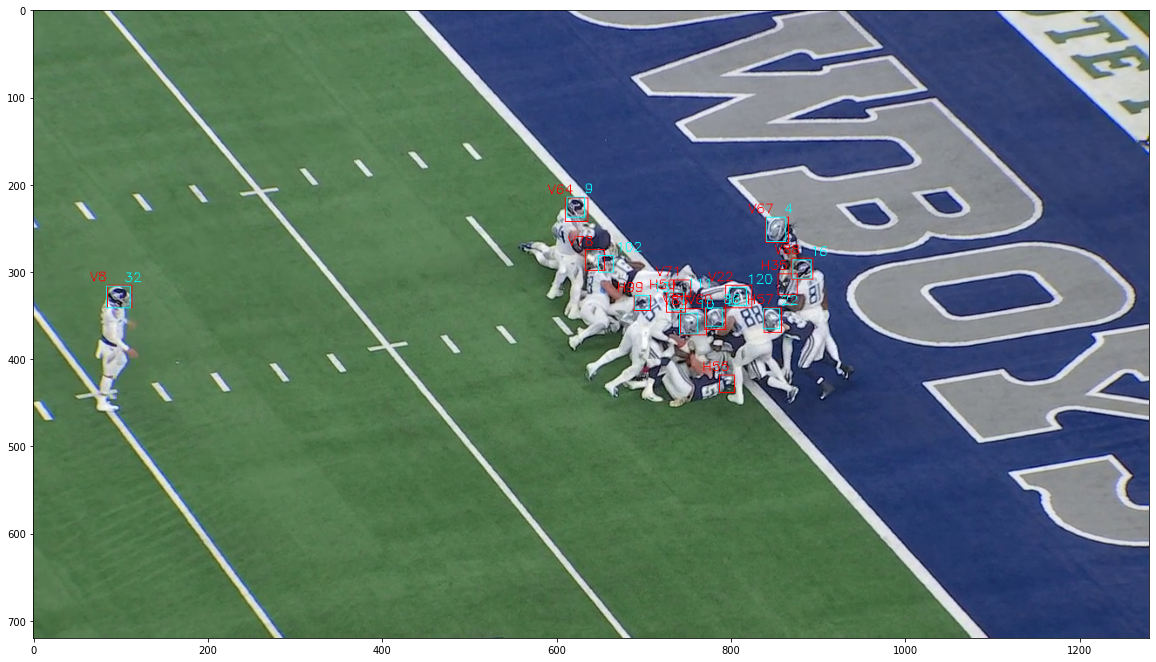

In [15]:
# Draw bboxes from both helmet tracking and FairMOT.

cap = cv2.VideoCapture(pth_video)
for _ in range(frame):
    read_ok, img = cap.read()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

_, ax = plt.subplots(figsize=(20, 16))

color_hmap = (255, 0, 0)
for box in df_hmap.itertuples():
    img = cv2.rectangle(img,
                        pt1=(box.left, box.top), 
                        pt2=(box.left + box.width, box.top + box.height), 
                        color=color_hmap, thickness=1)
    img = cv2.putText(img, 
                      text=box.label, 
                      org=(box.left - 20, box.top - 5), 
                      fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                      fontScale=0.5, color=color_hmap, thickness=1)

color_fmot = (0, 255, 255)
for box in df_fmot.itertuples():
    img = cv2.rectangle(img, 
                        pt1=(box.left, box.top), 
                        pt2=(box.left + box.width, box.top + box.height), 
                        color=color_fmot, thickness=1)
    img = cv2.putText(img, 
                      text=str(box.fairmot_cluster),
                      org=(box.left + 20, box.top - 5),
                      fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                      fontScale=0.5, color=color_fmot, thickness=1)
    
ax.imshow(img);

In [16]:
%%time

# Sort by 'left', then merge by matching the nearest left

df_hmap.sort_values(['left'], axis=0, inplace=True)
df_fmot.sort_values(['left'], axis=0, inplace=True)
df_merged = pd.merge_asof(df_hmap, df_fmot, on='left', direction='nearest', suffixes=('', '_fairmot'))

CPU times: user 6.69 ms, sys: 959 µs, total: 7.65 ms
Wall time: 11 ms


In [17]:
%%time

# For duplicated fairmot_cluster, choose the best matched top.
# Note this removes excess baseline helmets
df_merged['dtop'] = (df_merged['top'] - df_merged['top_fairmot']).abs()
df_merged.sort_values('dtop', inplace=True)
df_merged = df_merged.groupby('fairmot_cluster').first().reset_index()

CPU times: user 7.74 ms, sys: 230 µs, total: 7.97 ms
Wall time: 12.2 ms


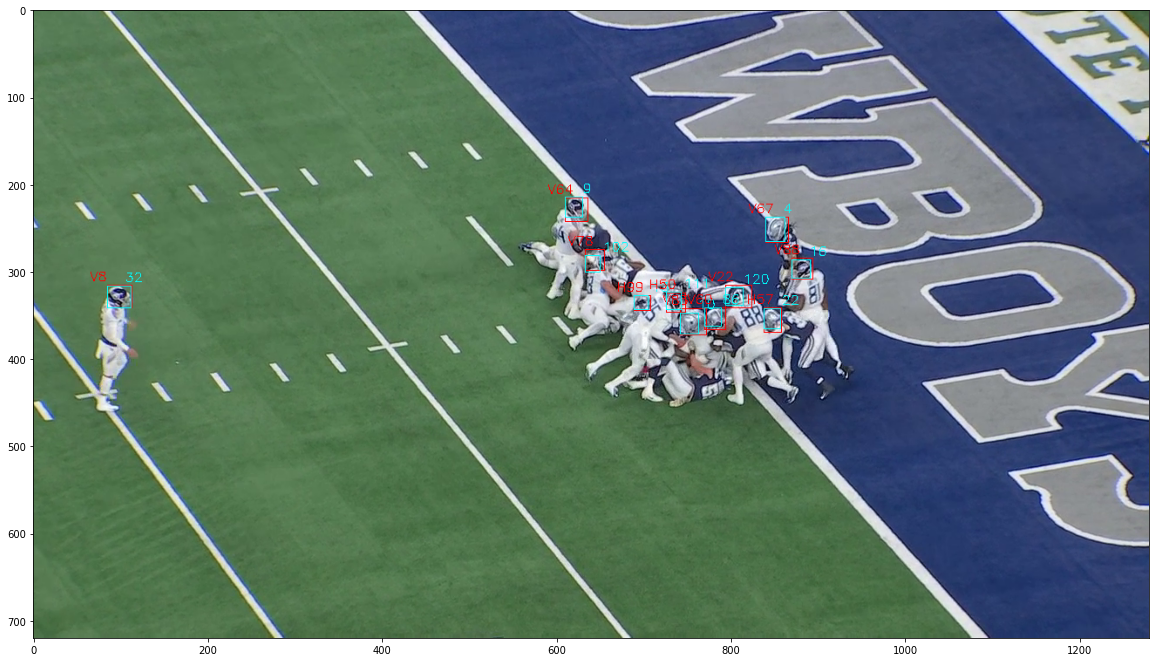

In [18]:
cap = cv2.VideoCapture(pth_video)
for _ in range(frame):
    read_ok, img = cap.read()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

_, ax = plt.subplots(figsize=(20, 16))

color_hmap = (255, 0, 0)
color_fmot = (0, 255, 255) 
for r in df_merged.itertuples():
    img = cv2.rectangle(img,
                        pt1=(r.left, r.top), 
                        pt2=(r.left + r.width, r.top + r.height), 
                        color=color_hmap, thickness=1)
    img = cv2.putText(img, 
                      text=r.label, 
                      org=(r.left - 20, r.top - 5), 
                      fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                      fontScale=0.5, color=color_hmap, thickness=1)
    
    img = cv2.rectangle(img,
                        pt1=(r.left, r.top_fairmot), 
                        pt2=(r.left + r.width_fairmot, r.top_fairmot + r.height_fairmot), 
                        color=color_fmot, thickness=1)
    img = cv2.putText(img, 
                      text=str(r.fairmot_cluster), 
                      org=(r.left + 20, r.top_fairmot - 5), 
                      fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                      fontScale=0.5, color=color_fmot, thickness=1)    

ax.imshow(img);